<a href="https://colab.research.google.com/github/saktiworkstation/GNNs-LLMs-Research/blob/main/GNN_(Teacher_Student)_%2B_Knowledge_Distillation_%2B_LLM_Summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch-geometric
!pip install transformers

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

# LLM
from transformers import AutoModelForCausalLM, AutoTokenizer

In [3]:
dataset_name = 'CiteSeer'
dataset = Planetoid(root='data/CiteSeer', name=dataset_name)

data = dataset[0]

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

In [5]:
print("===== INFORMASI DATASET =====")
print(f"Nama Dataset      : {dataset_name}")
print(f"Jumlah Graph      : {len(dataset)}")
print(f"Jumlah Fitur      : {dataset.num_features}")
print(f"Jumlah Kelas      : {dataset.num_classes}")
print(f"Jumlah Node       : {data.num_nodes}")
print(f"Jumlah Edge       : {data.num_edges}")
print(f"Average Node Degree : {data.num_edges / data.num_nodes:.2f}")
print(f"Jumlah Training Nodes : {data.train_mask.sum().item()}")
print(f"Jumlah Validation Nodes : {data.val_mask.sum().item()}")
print(f"Jumlah Test Nodes : {data.test_mask.sum().item()}\n")

===== INFORMASI DATASET =====
Nama Dataset      : CiteSeer
Jumlah Graph      : 1
Jumlah Fitur      : 3703
Jumlah Kelas      : 6
Jumlah Node       : 3327
Jumlah Edge       : 9104
Average Node Degree : 2.74
Jumlah Training Nodes : 120
Jumlah Validation Nodes : 500
Jumlah Test Nodes : 1000



In [6]:
labels = data.y
unique_labels, counts_labels = torch.unique(labels, return_counts=True)
print("\n=== DISTRIBUSI KELAS ===")
for lab, count in zip(unique_labels, counts_labels):
    print(f"Kelas {lab.item()}: {count.item()} node")

print("\n=== EDGE SAMPLE ===")
print(data.edge_index[:, :10])


=== DISTRIBUSI KELAS ===
Kelas 0: 264 node
Kelas 1: 590 node
Kelas 2: 668 node
Kelas 3: 701 node
Kelas 4: 596 node
Kelas 5: 508 node

=== EDGE SAMPLE ===
tensor([[ 628,  158,  486, 1097, 2919, 2933, 3285, 1431, 3219,  467],
        [   0,    1,    1,    1,    1,    1,    2,    3,    3,    4]])


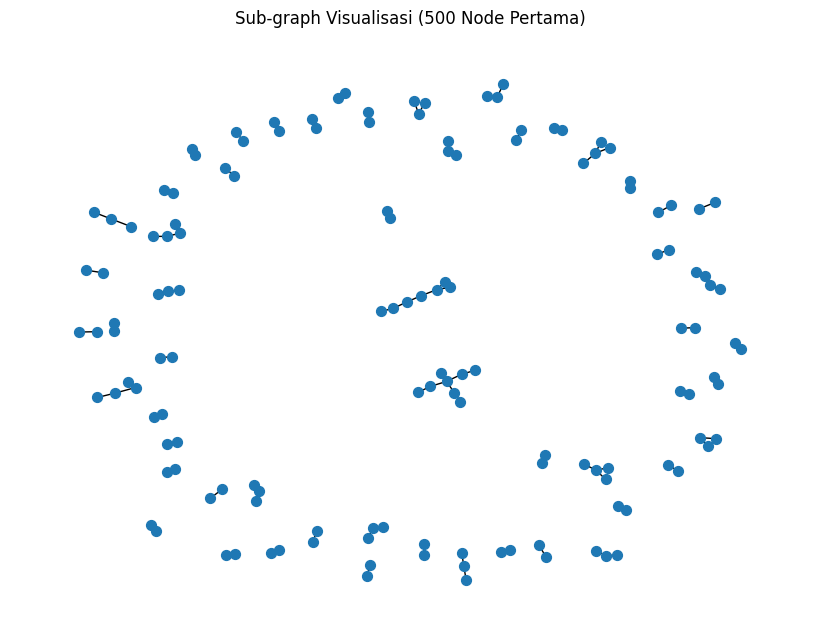

In [7]:
import matplotlib.pyplot as plt
import networkx as nx

sub_node_count = 500
sub_edge_mask = (data.edge_index[0] < sub_node_count) & (data.edge_index[1] < sub_node_count)
sub_edge_index = data.edge_index[:, sub_edge_mask]

sub_G = nx.Graph()
sub_edges = list(zip(sub_edge_index[0].tolist(), sub_edge_index[1].tolist()))
sub_G.add_edges_from(sub_edges)

plt.figure(figsize=(8, 6))
nx.draw(sub_G, node_size=50)
plt.title("Sub-graph Visualisasi (500 Node Pertama)")
plt.show()

# GCN MODEL

**Teacher GNN (3 Lapisan GCN)**

In [8]:
class TeacherGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(TeacherGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        return x  # logits sebelum softmax

**Student GNN (2 Lapisan GCN)**

In [9]:
class StudentGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(StudentGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x  # logits sebelum softmax

**TRAINING & EVALUATION**

In [10]:
def evaluate(model, data):
    model.eval()
    logits = model(data.x, data.edge_index)
    preds = logits.argmax(dim=1)

    accs = []
    for mask_name, mask in zip(
        ["Train", "Validation", "Test"],
        [data.train_mask, data.val_mask, data.test_mask]
    ):
        correct = preds[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    return accs  # [train_acc, val_acc, test_acc]


**TRAIN TEACHER**

In [11]:
teacher_model = TeacherGCN(
    in_channels=dataset.num_features,
    hidden_channels=64,
    out_channels=dataset.num_classes
).to(device)

teacher_optimizer = torch.optim.Adam(teacher_model.parameters(), lr=0.01, weight_decay=5e-4)

def train_teacher(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    logits = model(data.x, data.edge_index)
    loss = F.cross_entropy(logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

print("===== TRAINING TEACHER GCN =====")
for epoch in range(1, 101):  # Atur sesuai kebutuhan
    loss_t = train_teacher(teacher_model, data, teacher_optimizer)
    if epoch % 20 == 0:
        train_acc_t, val_acc_t, test_acc_t = evaluate(teacher_model, data)
        print(f"Epoch: {epoch:03d}, Loss: {loss_t:.4f}, "
              f"Train Acc: {train_acc_t:.4f}, Val Acc: {val_acc_t:.4f}, Test Acc: {test_acc_t:.4f}")

===== TRAINING TEACHER GCN =====
Epoch: 020, Loss: 0.0116, Train Acc: 1.0000, Val Acc: 0.6700, Test Acc: 0.6390
Epoch: 040, Loss: 0.0321, Train Acc: 1.0000, Val Acc: 0.6860, Test Acc: 0.6580
Epoch: 060, Loss: 0.0163, Train Acc: 1.0000, Val Acc: 0.6640, Test Acc: 0.6480
Epoch: 080, Loss: 0.0030, Train Acc: 1.0000, Val Acc: 0.6720, Test Acc: 0.6460
Epoch: 100, Loss: 0.0033, Train Acc: 1.0000, Val Acc: 0.6720, Test Acc: 0.6340


In [12]:
train_acc_t, val_acc_t, test_acc_t = evaluate(teacher_model, data)
print("\n===== HASIL AKHIR TEACHER =====")
print(f"Train Acc: {train_acc_t:.4f}")
print(f"Val Acc  : {val_acc_t:.4f}")
print(f"Test Acc : {test_acc_t:.4f}\n")


===== HASIL AKHIR TEACHER =====
Train Acc: 1.0000
Val Acc  : 0.6720
Test Acc : 0.6340



**KNOWLEDGE DISTILLATION**

In [13]:
def distillation_loss(student_logits, teacher_logits, labels, mask, alpha=0.5, temperature=2.0):
    """
    student_logits: output logits dari student
    teacher_logits: output logits dari teacher (tanpa softmax)
    labels        : label ground-truth
    mask          : node mask (train set)
    alpha         : rasio campuran antara CE dan KL
    temperature   : faktor skala temperatur

    Return gabungan CrossEntropy (dengan label asli) dan KL Divergence (dengan soft label teacher)
    """

    # Hard label loss (CE)
    ce_loss = F.cross_entropy(student_logits[mask], labels[mask])

    # Soft label loss (KL Divergence) dengan temperature
    # Softmax(teacher/Temp) vs logSoftmax(student/Temp)
    student_probs = F.log_softmax(student_logits[mask] / temperature, dim=1)
    teacher_probs = F.softmax(teacher_logits[mask] / temperature, dim=1)

    kl_div = F.kl_div(student_probs, teacher_probs, reduction="batchmean") * (temperature ** 2)

    loss = alpha * ce_loss + (1 - alpha) * kl_div
    return loss

In [14]:
student_model = StudentGCN(
    in_channels=dataset.num_features,
    hidden_channels=32,  # Lebih kecil dari teacher
    out_channels=dataset.num_classes
).to(device)

student_optimizer = torch.optim.Adam(student_model.parameters(), lr=0.01, weight_decay=5e-4)

def train_student_distill(teacher, student, data, optimizer, alpha=0.5, temperature=2.0):
    """
    Melatih student model dengan memanfaatkan soft logits dari teacher.
    """
    student.train()
    teacher.eval()  # teacher tidak di-train

    optimizer.zero_grad()

    with torch.no_grad():
        teacher_logits = teacher(data.x, data.edge_index)
    student_logits = student(data.x, data.edge_index)

    loss = distillation_loss(
        student_logits, teacher_logits, data.y, data.train_mask,
        alpha=alpha, temperature=temperature
    )
    loss.backward()
    optimizer.step()
    return loss.item()

print("===== DISTILLATION: TRAIN STUDENT GCN =====")
for epoch in range(1, 101):  # Bisa atur sesuai kebutuhan
    loss_s = train_student_distill(teacher_model, student_model, data, student_optimizer,
                                   alpha=0.5, temperature=2.0)
    if epoch % 20 == 0:
        train_acc_s, val_acc_s, test_acc_s = evaluate(student_model, data)
        print(f"Epoch: {epoch:03d}, Loss: {loss_s:.4f}, "
              f"Train Acc: {train_acc_s:.4f}, Val Acc: {val_acc_s:.4f}, Test Acc: {test_acc_s:.4f}")

===== DISTILLATION: TRAIN STUDENT GCN =====
Epoch: 020, Loss: 0.1312, Train Acc: 1.0000, Val Acc: 0.6480, Test Acc: 0.6470
Epoch: 040, Loss: 0.0841, Train Acc: 1.0000, Val Acc: 0.6540, Test Acc: 0.6520
Epoch: 060, Loss: 0.0554, Train Acc: 1.0000, Val Acc: 0.6780, Test Acc: 0.6740
Epoch: 080, Loss: 0.0628, Train Acc: 1.0000, Val Acc: 0.6900, Test Acc: 0.6830
Epoch: 100, Loss: 0.0599, Train Acc: 1.0000, Val Acc: 0.6860, Test Acc: 0.6860


In [15]:
train_acc_s, val_acc_s, test_acc_s = evaluate(student_model, data)
print("\n===== HASIL AKHIR STUDENT (DISTILLED) =====")
print(f"Train Acc: {train_acc_s:.4f}")
print(f"Val Acc  : {val_acc_s:.4f}")
print(f"Test Acc : {test_acc_s:.4f}\n")


===== HASIL AKHIR STUDENT (DISTILLED) =====
Train Acc: 1.0000
Val Acc  : 0.6860
Test Acc : 0.6860



**INTEGRASI LLM (HASIL)**

In [16]:
model_name = "gpt2"  # Model GPT-2 kecil, dapat diganti yang lain
tokenizer = AutoTokenizer.from_pretrained(model_name)
gpt2_model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

def generate_summary(teacher_scores, student_scores):
    """
    teacher_scores: (train_acc_t, val_acc_t, test_acc_t)
    student_scores: (train_acc_s, val_acc_s, test_acc_s)
    """
    (train_t, val_t, test_t) = teacher_scores
    (train_s, val_s, test_s) = student_scores

    prompt_text = (
        f"Saya baru saja melatih dua model GNN pada dataset CiteSeer: "
        f"Teacher (3 lapisan) dan Student (2 lapisan) dengan teknik knowledge distillation.\n\n"
        f"Hasil akhir Teacher GNN:\n"
        f"- Akurasi Train: {train_t:.2f}\n"
        f"- Akurasi Val  : {val_t:.2f}\n"
        f"- Akurasi Test : {test_t:.2f}\n\n"
        f"Setelah distillation, Student GNN mencapai:\n"
        f"- Akurasi Train: {train_s:.2f}\n"
        f"- Akurasi Val  : {val_s:.2f}\n"
        f"- Akurasi Test : {test_s:.2f}\n\n"
        f"Ringkaskan hasil tersebut secara singkat:"
    )

    inputs = tokenizer.encode(prompt_text, return_tensors='pt').to(device)
    summary_ids = gpt2_model.generate(
        inputs,
        max_new_tokens=150,
        num_beams=2,
        no_repeat_ngram_size=2,
        early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [17]:
teacher_scores = (train_acc_t, val_acc_t, test_acc_t)
student_scores = (train_acc_s, val_acc_s, test_acc_s)
summary_result = generate_summary(teacher_scores, student_scores)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [18]:
print("===== RINGKASAN LLM (GPT-2) =====")
print(summary_result)

===== RINGKASAN LLM (GPT-2) =====
Saya baru saja melatih dua model GNN pada dataset CiteSeer: Teacher (3 lapisan) dan Student (2 lapisan) dengan teknik knowledge distillation.

Hasil akhir Teacher GNN:
- Akurasi Train: 1.00
- Akurasi Val  : 0.67
- Akurasi Test : 0.63

Setelah distillation, Student GNN mencapai:
- Akurasi Train: 1.00
- Akurasi Val  : 0.69
- Akurasi Test : 0.69

Ringkaskan hasil tersebut secara singkat: teacher gai-teacher gi-student gan-studio gani-school gana-class gansa-tribal gannam-museum gao-cities gantas-city gancho-gantar gakkad-bazaar gar-kara gatkana gayat-laboratory gah-shanty gawat gabat kara-dance gajat dal-japan gazat lama-labour gavat bazaar karat pata-shop galat nakat takka-store gala-house gagat mga-pantry gachat hu-h


- GPT-2 yang “polos” bukanlah model summarization yang dikhususkan merangkum teks
saintifik atau laporan hasil GNN, sehingga hasilnya bisa terlihat kacau.
- Untuk mendapatkan ringkasan yang lebih baik, pertimbangkan menggunakan model summarization khusus, melakukan fine-tuning, atau menyesuaikan parameter decoding.
- Dengan prompt engineering yang lebih baik dan pemilihan model yang tepat, kualitas ringkasan dapat meningkat signifikan.